In [1]:
import libs.mdn as mdn

In [2]:
from model import *
import pytchat
from data import *

C:\Users\avika\OneDrive\Documents\UAL\interactive_dance_thesis


In [3]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="michellejieli/emotion_text_classifier")
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")
model = AutoModelForSequenceClassification.from_pretrained("michellejieli/emotion_text_classifier")

In [7]:
args = argparse.Namespace(
        BATCH_SIZE=1,
        BLOCK_SIZE=16,
        DROPOUT=0.2,
        LEARNING_RATE=0.0001,
        EPOCHS=100000,
        FRAMES_GENERATE=150,
        TRAIN=False,
        EVAL_EVERY=1000,
        CHECKPOINT_PATH="checkpoints/proto8_checkpoint.pth",
        L1_LAMBDA=None,
        L2_REG=0.0,
        FINETUNE=False,
        FINE_TUNING_LR=1e-5,
        FINE_TUNING_EPOCHS=100000,
        PENALTY=False,
        LATENT_VIS_EVERY=1000,
        USE_MDN = True,
        DATASET = "all",
        
        # NOTES---------------------------------
        notes = f"""Proto8 - trying to adapt Pette et al 2019, addign latent visualisation and analysing latent space. Might be slow, maybe take this out when live.
        
        Added MDN to increase variance of output as Bishop et al 1994. and Alemi et al 2017.
        
        MEED data only

        All data, added 10% noise to emotions so model is less stuck. With LeakyRelu
        Loss = mse_loss(keypoints) + mse_loss(emotions) because before output emotions ( which feature was added to keypoint features) were not being matched to input emotions
        No penalty.

        Added dropout to keypoints, also changed input to emotion linear to x and not just emotion (emotion + keypoints)
        Taking extra dropout for emotions and keypoints out, because want model to rely on both equally so what's the point

        dropout keypoints and dropout emotion is currently equal but might change this.

        Emotions and keypoints are multimodal and added separately, but features are added in block processing using +.


        Got rid of both L1 and L2, increasing dropout because model acting weird, this is now delta + coord. 
        Delta is between next frame and current frame. So current frame is previous coord+previous delta. Last frame's delta is 0. 
        """
    )

In [11]:
# If args are provided, use those; otherwise, parse from command line
if args is None:
    args = parse_args()

# Set the global variables based on args
set_globals(args)

# Set global variables

processed_data= prep_data(dataset=args.DATASET)
global train_data,train_emotions, val_data, val_emotions, frame_dim, max_x, min_x, max_y, min_y, max_dx, min_dx, max_dy, min_dy, threshold
train_data, train_emotions, val_data, val_emotions, frame_dim, max_x, min_x, max_y, min_y, max_dx, min_dx, max_dy, min_dy, threshold = processed_data

# create model
global m
m = MotionModel(input_dim=frame_dim, output_dim=frame_dim,emotion_dim=7, blocksize=args.BLOCK_SIZE, hidden_dim=512, n_layers=8, dropout=args.DROPOUT)
m = m.to(device)

global train_seed





    Batch size set to: 1
    Block size set to: 16
    Dropout rate set to: 0.2
    Learning rate set to: 0.0001
    Number of epochs set to: 100000
    Frames to generate set to: 150
    Training mode set to: False
    Evaluation every set to: 1000
    Checkpoint path set to: checkpoints/proto8_checkpoint.pth
    L1 regularization lambda set to: None
    L2 regularization lambda set to: 0.0
    Fine-tuning mode set to: False
    Fine-tuning learning rate set to: 1e-05
    Fine-tuning epochs set to: 100000
    Penalty flag set to: False
    Latent visualization every set to: 1000
    Use MDN flag set to: True
    Dataset set to: all
    
Preparing data for all...


100%|██████████| 4102/4102 [00:03<00:00, 1046.07it/s]


Validating interpolation...
No errors found!


4102it [00:01, 2311.59it/s]
4102it [00:01, 2447.01it/s]
100%|██████████| 109/109 [00:05<00:00, 21.15it/s]


Validating interpolation...
No errors found!


109it [00:00, 286.57it/s]
109it [00:00, 291.22it/s]


Creating keypoint frames...


100%|██████████| 4211/4211 [00:03<00:00, 1200.46it/s]


Creating keypoint frames...


100%|██████████| 4211/4211 [00:02<00:00, 1529.30it/s]


Validating length of dkp_frames
Validating length of kp_frames
Adding deltas to frames...


4211it [00:02, 1421.61it/s]


Validating length of data after delta
frame_dim: 100


In [12]:
optimizer = torch.optim.Adam(m.parameters(), lr=args.LEARNING_RATE, weight_decay=args.L2_REG)
    

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
# Load the model
print('Loading model...')
m, optimizer, scheduler, epoch, loss, train_seed = load_checkpoint(m, optimizer, args.CHECKPOINT_PATH,scheduler)
print(f"Model {train_seed} loaded from {args.CHECKPOINT_PATH} (epoch {epoch}, loss {loss:.6f})")

Loading model...
Loading checkpoint...
Checkpoint loaded from checkpoints/proto8_checkpoint.pth
Model 26166 loaded from checkpoints/proto8_checkpoint.pth (epoch 80000, loss -3.753968)


In [13]:
args.BATCH_SIZE

1

In [18]:
# Generate a sequence
print(f'Generating sequence of {args.FRAMES_GENERATE} frames...')
# xb and yb should always have the same emotion - because same video
xb, yb, eb, _ = get_batch("val", 3, args.BATCH_SIZE, train_data,train_emotions, val_data, val_emotions)

generated_keypoints,generated_emotion = m.generate(xb, eb, args.FRAMES_GENERATE)

unnorm_out = unnormalise_list_2D(generated_keypoints, max_x, min_x, max_y, min_y,max_x, min_x, max_y, min_y)

chosen_emotion = 'anger'
emotion_vectors = (eb[0],generated_emotion[0])
# visualise
visualise_skeleton(unnorm_out[0], max_x, max_y,emotion_vectors, max_frames=args.FRAMES_GENERATE,save = False,save_path=None,prefix=f'adam_{args.EPOCHS}_coord',train_seed=train_seed,delta=False)

Generating sequence of 150 frames...


Visualizing frames: 100%|██████████| 150/150 [00:16<00:00,  9.19it/s]


In [19]:
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

In [20]:

# def visualise_skeleton(all_frames, max_x, max_y, max_frames=500, save=False, save_path=None, prefix=None, train_seed=None , delta=False, destroy = True):
#     """Input all frames dim 50xn n being the number of frames 50= 25 keypoints x and y coordinates"""

    
#     # visualise to check if the data is correct
#     # BODY_25 Keypoints
#     keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
#                         'L-Elb', 'L-Wr', 'MidHip', 'R-Hip', 'R-Knee', 'R-Ank', 
#                         'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 
#                         'L-Ear', 'L-BigToe', 'L-SmallToe', 'L-Heel', 'R-BigToe', 
#                         'R-SmallToe', 'R-Heel']


#     limb_connections = [
#         ("Nose", "Neck"),
#         ("Neck", "R-Sho"),
#         ("R-Sho", "R-Elb"),
#         ("R-Elb", "R-Wr"),
#         ("Neck", "L-Sho"),
#         ("L-Sho", "L-Elb"),
#         ("L-Elb", "L-Wr"),
#         ("Neck", "MidHip"),
#         ("MidHip", "R-Hip"),
#         ("R-Hip", "R-Knee"),
#         ("R-Knee", "R-Ank"),
#         ("MidHip", "L-Hip"),
#         ("L-Hip", "L-Knee"),
#         ("L-Knee", "L-Ank"),
#         ("Nose", "R-Eye"),
#         ("R-Eye", "R-Ear"),
#         ("Nose", "L-Eye"),
#         ("L-Eye", "L-Ear"),
#         ("L-Ank", "L-BigToe"),
#         ("L-Ank", "L-SmallToe"),
#         ("L-Ank", "L-Heel"),
#         ("R-Ank", "R-BigToe"),
#         ("R-Ank", "R-SmallToe"),
#         ("R-Ank", "R-Heel")
#     ]
    
#      # Define a mapping from emotion vectors to emotion labels
#     # Define emotion labels
#     emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']
    
#     # Initialize a blank canvas (image)
#     canvas_size = (int(max_y)+50, int(max_x)+50, 3)  
#     canvas = np.zeros(canvas_size, dtype=np.uint8)
    
    
#     if save:
#         # Determine the save path
#         if save_path is None:
#             save_path = f"D:\\Interactive Dance Thesis Tests\\TransformerResults\\{train_seed}"

#         # Ensure directory exists
#         if not os.path.exists(save_path):
#             print(f"Creating directory {save_path}")
#             os.makedirs(save_path)

#         # Determine a unique filename
#         existing_files = os.listdir(save_path)
#         file_num = 1
#         while f"{prefix or ''}{file_num}.mp4" in existing_files:
#             file_num += 1
#         out_path = os.path.join(save_path, f"{prefix or ''}{file_num}.mp4")

#         # Create the video writer
#         fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#         out = cv2.VideoWriter(out_path, fourcc, 10.0, (canvas_size[1], canvas_size[0]))
    
#     previous_frame_data = None
    
#     # Iterate over all frames; the first frame uses absolute keypoints, the rest use relative keypoints (deltas)
#     for frame_data in tqdm(all_frames[:max_frames], desc="Visualizing frames"):
        
#         # If previous_frame_data is None, this is the first frame and we use absolute positions.
#         # Otherwise, add the delta to the previous frame's keypoints to get the new keypoints
#         if delta ==True:
#             if previous_frame_data is not None:
#                 frame_data[:50] = [prev + delta for prev, delta in zip(previous_frame_data[:50], frame_data[50:100])]
        
#             # Update previous_frame_data
#             previous_frame_data = copy.deepcopy(frame_data)
        
#         canvas_copy = canvas.copy()
        
#         # Extract x, y coordinates and emotion vector
#         x_coords = frame_data[0:50:2] 
#         y_coords = frame_data[1:50:2]
#         emotion_vector = tuple(frame_data[100:107])
        
#         xy_coords = list(zip(x_coords, y_coords))
#         sane = sanity_check(xy_coords)
#         # Plot keypoints on the canvas
#         for i, (x, y) in enumerate(xy_coords):
#             if sane[i] == False:
#                 continue
#             x_val = x.item() if torch.is_tensor(x) else x
#             y_val = y.item() if torch.is_tensor(y) else y
#             cv2.circle(canvas_copy, (int(x_val), int(y_val)), 3, (0, 0, 255), -1)  
#             cv2.putText(canvas_copy, keypointsMapping[i], (int(x_val), int(y_val)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

#         # Draw connections (limbs) on the canvas
#         for limb in limb_connections:
#             start_idx = keypointsMapping.index(limb[0])
#             end_idx = keypointsMapping.index(limb[1])
            
#             start_point = (int(x_coords[start_idx]), int(y_coords[start_idx]))
#             end_point = (int(x_coords[end_idx]), int(y_coords[end_idx]))

#             if start_point == (0,0) or end_point == (0,0) or not sane[start_idx] or not sane[end_idx]:
#                 continue
#             cv2.line(canvas_copy, start_point, end_point, (0, 255, 0), 2)  
        
#         # Display the emotion percentages and labels on the top right of the frame
        
#         emotion_percentages = [f"{int(e * 100)}% {emotion_labels[i]}" for i, e in enumerate(emotion_vector) if round(e * 100) > 1]
#         # print(emotion_percentages)
#         y0, dy = 30, 15  # Starting y position and line gap
#         for i, line in enumerate(emotion_percentages):
#             y = y0 + i * dy
#             cv2.putText(canvas_copy, line, (canvas_size[1] - 120, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)


#         # Display the canvas with keypoints and connections
#         cv2.imshow("Keypoints Visualization", canvas_copy)

#         # If saving, write the frame to the video
#         if save:
#             out.write(canvas_copy)

#         # Wait for 100ms and check for "esc" key press to exit
#         key = cv2.waitKey(100)
#         if key == 27:  
#             break

#     # Release the video writer, if used
#     if save:
#         out.release()

#     if destroy:
#         # Close the visualization window
#         cv2.destroyAllWindows()


In [ ]:


# Initialize a dictionary to keep track of cumulative scores and counts for each emotion
emotion_data = {emotion: {"score": 0.0, "count": 0} for emotion in emotion_labels}


# List to store average scores indexed by emotions
average_scores = [0.0 for _ in emotion_labels]
length =0

BLOCK_SIZE = 16 # what is the maximum context length for predictions? 

# create model
CHECKPOINT_PATH = "checkpoints/proto8_checkpoint_MEED.pth"

m = MotionModel(input_dim=frame_dim, output_dim=frame_dim, blocksize=BLOCK_SIZE, hidden_dim=512, n_layers=8, dropout=DROPOUT)
m = m.to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)  # weight_decay=1e-5 L2 regularization
m, optimizer,scheduler, epoch, loss, train_seed = load_checkpoint(m, optimizer, CHECKPOINT_PATH)
print(f"training seed: {train_seed}")


In [ ]:
FRAMES_GENERATE = 150



chosen_emotion = "Fear"
# seems like 150 frames is good before it get's a bit weird

specific_emotion_video = get_video_by_emotion(train_data, chosen_emotion)

# initial generation always neutral

generated_keypoints,generated_emotion = m.generate(specific_emotion_video[:-1], emotion_in, FRAMES_GENERATE)
unnorm_out = unnormalise_list_2D(generated, max_x, min_x, max_y, min_y,max_x, min_x, max_y, min_y)

# visualise
visualise_skeleton(unnorm_out[0], max_x, max_y, max_frames=FRAMES_GENERATE,save = True,save_path=None,prefix=f'{chosen_emotion}_{epoch}_coord',train_seed=train_seed,delta=False)


# have to normalise the generated data before putting it into the model

In [22]:
# Generate a sequence using random noise

print(f'Generating sequence of {args.FRAMES_GENERATE} frames...')
# xb and yb should always have the same emotion - because same video
xb, yb, eb, _ = get_batch("val", 3, args.BATCH_SIZE, train_data,train_emotions, val_data, val_emotions)
noise = torch.randn(1, 5, 100).to(device)
print(noise.shape)  # Should print: torch.Size([1, 97, 107])

generated_keypoints,generated_emotion = m.generate(noise, eb, args.FRAMES_GENERATE)

unnorm_out = unnormalise_list_2D(generated_keypoints, max_x, min_x, max_y, min_y,max_x, min_x, max_y, min_y)

emotion_vectors = (eb[0],generated_emotion[0])
# visualise
visualise_skeleton(unnorm_out[0], max_x, max_y,emotion_vectors, max_frames=args.FRAMES_GENERATE,save = True,save_path=None,prefix=f'noise_generated_main_{args.EPOCHS}_coord',train_seed=train_seed,delta=False)

Generating sequence of 150 frames...
torch.Size([1, 5, 100])


Visualizing frames: 100%|██████████| 150/150 [00:16<00:00,  9.11it/s]


In [ ]:
def normalise_generated(unnorm_out, max_x, min_x, max_y, min_y, max_dx, min_dx, max_dy, min_dy):
    norm_out = []
    
    for frame in unnorm_out:
        norm_frame = []
        
        # Normalize the first 50 values (absolute x and y coordinates)
        for i in range(0, 50, 2):
            unnormalized_x = frame[i]
            unnormalized_y = frame[i+1]
            
            norm_x = 2 * (unnormalized_x - min_x) / (max_x - min_x) - 1
            norm_y = 2 * (unnormalized_y - min_y) / (max_y - min_y) - 1
            
            norm_frame.extend([norm_x, norm_y])
        
        # Normalize the second 50 values (x and y deltas)
        for i in range(50, 100, 2):
            unnormalized_dx = frame[i]
            unnormalized_dy = frame[i+1]
            
            norm_dx = 2 * (unnormalized_dx - min_dx) / (max_dx - min_dx) - 1
            norm_dy = 2 * (unnormalized_dy - min_dy) / (max_dy - min_dy) - 1
            
            norm_frame.extend([norm_dx, norm_dy])
        
        # Append the emotion encoding without normalizing
        norm_frame.extend(frame[-7:])
        norm_out.append(norm_frame)
        
    return norm_out


In [ ]:
import threading
import queue
import time
import keyboard
import queue


In [ ]:
import glob

files = glob.glob("D:/Interactive Dance Thesis Tests/TransformerResults/*/*500000*")
print(files)

In [ ]:

# Initial setup
shared_data = {
    'average_scores': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
}

chat = pytchat.create(video_id="gCNeDWCI0vo")
FRAMES_GENERATE = 150
terminate_threads = False

# This queue will hold the batches ready for visualization
viz_queue = queue.Queue()


def process_chat_message(c):
    """Process a chat message and update emotion scores."""
    print(f"{c.datetime} [{c.author.name}]- {c.message}")
    result = pipe(c.message)  # Assuming pipe() returns emotion prediction
    print(result)

    detected_emotion = result[0]['label']

    # Reset the counter for the detected emotion and boost its score
    emotion_data[detected_emotion]["count"] = 0
    score = result[0]['score']
    emotion_data[detected_emotion]["score"] = min(1, emotion_data[detected_emotion]["score"] + score)

    # Decay scores for other emotions and increase their counters
    for emotion, data in emotion_data.items():
        if emotion != detected_emotion:
            data["count"] += 1
            if data["count"] >= 5:
                data["score"] = 0
            else:
                data["score"] *= 0.5  # or any other decay factor you prefer

    # Update average scores
    for i, emotion in enumerate(emotion_labels):
        shared_data['average_scores'][i] = emotion_data[emotion]["score"]

    print("Average scores:", shared_data['average_scores'])


INPUT_LENGTH = 1

# Batch generation function
def generate_new_batch():
    """Generate a new batch based on the current average scores."""
    last_frames = unnorm_out[0][-INPUT_LENGTH:]
    norm_last_frames = normalise_generated(last_frames, max_x, min_x, max_y, min_y, max_x, min_x, max_y, min_y)
    new_batch = [frame[:-7] + shared_data['average_scores'] for frame in norm_last_frames]
    new_input = torch.tensor([new_batch]).to(device).float()

    # Generate the new frames
    generated = m.generate(new_input, FRAMES_GENERATE)
    return unnormalise_list_2D(generated, max_x, min_x, max_y, min_y, max_x, min_x, max_y, min_y)

# Periodic batch generation function - secs
def generate_batches_periodically(period=2):
    """Periodically generate batches and put them in the visualization queue."""
    while True:
        time.sleep(period)
        unnorm_out = generate_new_batch()
        viz_queue.put(unnorm_out)
        
def visualise(unnorm_out):
    # visualize
    visualise_skeleton(unnorm_out[0], max_x, max_y, max_frames=FRAMES_GENERATE,save = False,save_path=None,prefix=f'adam_{EPOCHS}_coord_switchhappytodisgust',train_seed=train_seed,delta=False,destroy=False)

# Visualization thread
def visualise_batches():
    while True:
        # Wait for a new batch to be available in the queue
        unnorm_out = viz_queue.get()
        
        # visualise the batch
        visualise(unnorm_out)

# Start the threads
threading.Thread(target=visualise_batches, daemon=True).start()
threading.Thread(target=generate_batches_periodically, args=(10,), daemon=True).start()

# Process chat messages
length = 0
while chat.is_alive():
    if keyboard.is_pressed('esc'):  # Check if ESC key is pressed
        terminate_threads = True
        break  # Exit the main loop
    for c in chat.get().sync_items():
        process_chat_message(c)
        length += 1
        
cv2.destroyAllWindows()


In [ ]:
from pytube import YouTube

yt = YouTube('https://www.youtube.com/watch?v=OlmMP2Z83Pg')
yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution') .desc().first().download()

In [ ]:
import os
import pandas as pd
import subprocess
from tqdm import tqdm

def download_videos(csv_path, output_dir):
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load the CSV file
    df = pd.read_csv(csv_path, header=None, names=["video_url"])

    # Iterate over the video URLs in the CSV file
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Downloading videos"):
        video_url = row['video_url']  # Assuming the column name is 'video_url'
        video_name = os.path.basename(video_url)
        output_path = os.path.join(output_dir, video_name)

        # Download the video using wget
        subprocess.run(['wget', '-O', output_path, video_url, '--show-progress'])

if __name__ == "__main__":
    csv_path = "G:/Downloads/refined_10M_all_video_url.csv"
    output_dir = "G:/UAL_Thesis/affective_computing_datasets/AIST"
    download_videos(csv_path, output_dir)


In [ ]:
import glob
files = glob.glob("G:\\UAL_Thesis\\affective_computing_datasets\\DanceDBrenders\\DanceDB\\*\\*_keypoints.txt")
files

In [ ]:
emotions_set = {
    'Happy', 'Miserable', 'Relaxed', 'Sad', 'Satisfied', 'Tired', 
    'Excited', 'Afraid', 'Angry', 'Annoyed', 'Bored', 'Pleased',
    'Neutral','Nervous','Mix','Curiosity'
}


emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']

In [ ]:
import glob

emotions_set = {
    'Happy', 'Miserable', 'Relaxed', 'Sad', 'Satisfied', 'Tired', 
    'Excited', 'Afraid', 'Angry', 'Annoyed', 'Bored', 'Pleased',
    'Neutral', 'Nervous', 'Mix', 'Curiosity'
}

# Define the path pattern to load the files
path_pattern = "G:\\UAL_Thesis\\affective_computing_datasets\\DanceDBrenders\\DanceDB\\*\\*_keypoints.txt"

# Get the list of all files that match the pattern
files = glob.glob(path_pattern)

# Filter the files based on the keywords in emotions_set
filtered_files = [file for file in files if any(emotion.lower() in file.lower() for emotion in emotions_set)]

print("Filtered files:")
for file in filtered_files:
    print(file)


In [ ]:
import glob

emotions_set = {
    'Happy', 'Miserable', 'Relaxed', 'Sad', 'Satisfied', 'Tired', 
    'Excited', 'Afraid', 'Angry', 'Annoyed', 'Bored', 'Pleased',
    'Neutral', 'Nervous', 'Mix', 'Curiosity'
}

# Define the path pattern to load the files
path_pattern = "G:\\UAL_Thesis\\affective_computing_datasets\\DanceDBrenders\\DanceDB\\*\\*_keypoints.txt"

# Get the list of all files that match the pattern
files = glob.glob(path_pattern)

# Filter the files based on the keywords in emotions_set and return the matched emotion
filtered_files_and_emotions = [(file, emotion) for file in files for emotion in emotions_set if emotion.lower() in file.lower()]

print("Filtered files and matched emotions:")
for file, emotion in filtered_files_and_emotions:
    print(f"{file}: {emotion}")


In [ ]:
file_path = filtered_files[0]

with open(file_path, 'r') as file:
    content = file.read()
content

In [ ]:
import json

content_dict = json.load(content)


In [ ]:

len(content_dict)-25

In [ ]:
content_dict['941']

In [ ]:

from tqdm import tqdm
flattened_dict={}
for i in tqdm(range(len(content_dict)-25)):
    nested_list = content_dict[str(i)]
     
    flattened_dict[i] = [coordinate for sublist in nested_list for coordinate in (sublist if sublist is not None else [0, 0])]
flattened_dict

In [ ]:

from tqdm import tqdm
flattened_dict={}
x=[]
y=[]
for i in tqdm(range(len(content_dict)-25)):
    nested_list = content_dict[str(i)]
    x.extend([coordinate[0] if coordinate is not None else 0 for coordinate in nested_list])
    y.extend([coordinate[1] if coordinate is not None else 0 for coordinate in nested_list])

    


In [ ]:
from data import *

prep_data(dataset = "DanceDB")

In [ ]:
from model import *


In [21]:


def danceDB_emotions():
    # co pilot is really good at guessing emotions combinations
    return {
        'Happy': {'Happiness': 1.0},
        'Miserable': {'Sad': 1.0},
        'Relaxed': {'Neutral': 0.9, 'Happiness': 0.1},
        'Sad': {'Sad': 1.0},
        'Satisfied': {'Happiness': 1.0},
        'Tired': {'Neutral': 1.0},
        'Excited': {'Happiness': 0.9, 'Surprise': 0.1},
        'Afraid': {'Fear': 1.0},
        'Angry': {'Anger': 1.0},
        'Annoyed': {'Anger': 0.5, 'Disgust': 0.5},
        'Bored': {'Neutral': 0.8, 'Sad': 0.1, 'Anger': 0.1},
        'Pleased': {'Happiness': 1.0},
        'Neutral': {'Neutral': 1.0},
        'Nervous': {'Fear': 0.5, 'Surprise': 0.5},
        'Mix': {'Anger': 0.143, 'Disgust': 0.143, 'Fear': 0.143, 'Happiness': 0.143, 'Neutral': 0.143, 'Sad': 0.143, 'Surprise': 0.143},
        'Curiosity': {'Surprise': 0.3,'Happiness': 0.3,'Neutral': 0.3,'Fear': 0.1}
    }

def encode_danceDB_emotion(emotion):
    
    emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']
    
    emotion_mapping = danceDB_emotions()
    if emotion not in emotion_mapping:
        return "Emotion not found in mapping"
    
    encoding = [0.0] * len(emotion_labels)
    for emotion_label, percentage in emotion_mapping[emotion].items():
        if emotion_label in emotion_labels:
            index = emotion_labels.index(emotion_label)
            encoding[index] = percentage
    
    return encoding

# Test the function with an example
example_emotion = 'Annoyed'
encoded_emotion = encode_danceDB_emotion(example_emotion)
print(f"Encoding for '{example_emotion}': {encoded_emotion}")


Encoding for 'Annoyed': [0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]


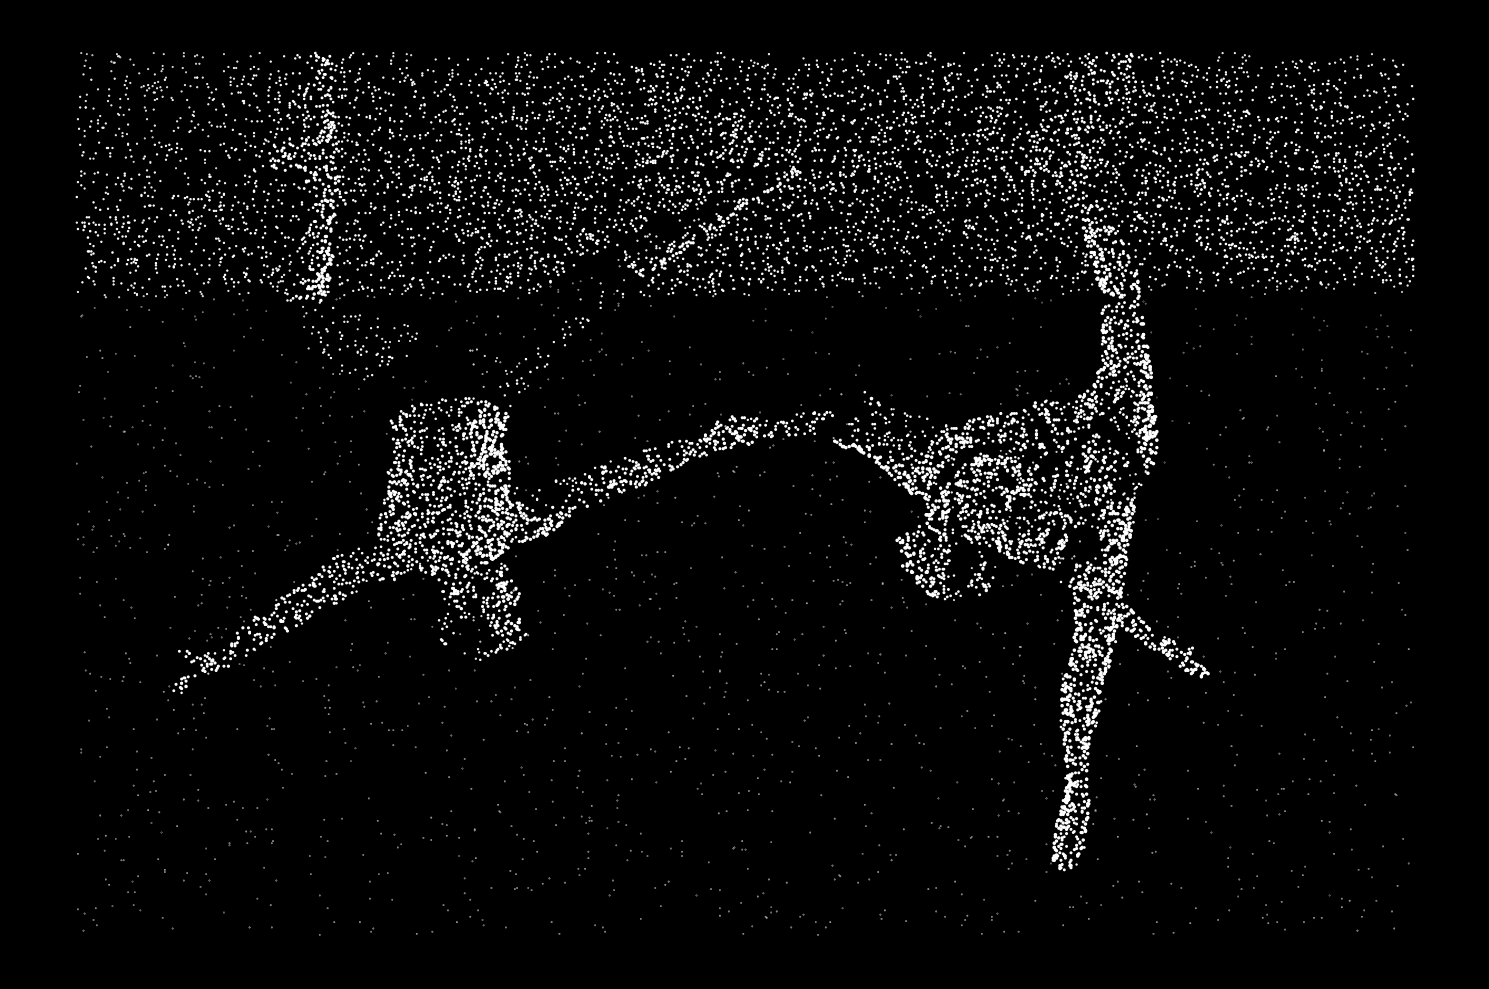

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Load the image and convert it to grayscale
image_path = 'data/test_pose.jpg'  # Replace with your image path
human_img = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert to numpy array and normalize
image_array = np.asarray(human_img) / 255.0

# Invert intensities for the stippling effect (darker areas have more dots)
intensity =  image_array

# Prepare a list to hold the dots
dots = []

# Define stippling parameters
num_dots = 100000  # total number of dots to be distributed
max_dot_size = 2.5  # maximum size of dot

# Generate dots
for _ in range(num_dots):
    x = random.randint(0, intensity.shape[1] - 1)
    y = random.randint(0, intensity.shape[0] - 1)
    
    # Use the inverted intensity as a probability weight for placing a dot
    if random.random() < intensity[y, x]:
        dot_size = intensity[y, x] * max_dot_size
        dots.append((x, y, dot_size))

# Plot the dots on a black canvas
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(*zip(*[(x, y) for x, y, size in dots]), s=[size for x, y, size in dots], color='white', marker='o')

# Set the background to black
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Remove axes for better visualization
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
!python smplifyx/main.py --config cfg_files/fit_smplx.yaml 
    --data_folder "data/smplx"
    --output_folder "data"
    --visualize="True"
    --model_folder "models/smplx"
    --vposer_ckpt VPOSER_FOLDER
    --part_segm_fn smplx_parts_segm.pkl

In [1]:
# Define the arguments you want to pass

from model import *

args = argparse.Namespace(
    BATCH_SIZE=8,
    BLOCK_SIZE=16,
    DROPOUT=0.2,
    LEARNING_RATE=0.0001,
    EPOCHS=300000,
    FRAMES_GENERATE=10,
    TRAIN=False,
    EVAL_EVERY=1000,
    CHECKPOINT_PATH="checkpoints/proto8_checkpoint.pth",
    L1_LAMBDA=None,
    L2_REG=0.0,
    FINETUNE=False,
    FINE_TUNING_LR=1e-5,
    FINE_TUNING_EPOCHS=100000,
    PENALTY=False,
    LATENT_VIS_EVERY=1000,
    USE_MDN = True,
    DATASET = "MEED",
    
    # NOTES---------------------------------
    notes = f"""Proto8 - trying to adapt Pette et al 2019, addign latent visualisation and analysing latent space. Might be slow, maybe take this out when live.
    
    Added MDN to increase variance of output as Bishop et al 1994. and Alemi et al 2017.
    
    MEED data only

    All data, added 10% noise to emotions so model is less stuck. With LeakyRelu
    Loss = mse_loss(keypoints) + mse_loss(emotions) because before output emotions ( which feature was added to keypoint features) were not being matched to input emotions
    No penalty.

    Added dropout to keypoints, also changed input to emotion linear to x and not just emotion (emotion + keypoints)
    Taking extra dropout for emotions and keypoints out, because want model to rely on both equally so what's the point

    dropout keypoints and dropout emotion is currently equal but might change this.

    Emotions and keypoints are multimodal and added separately, but features are added in block processing using +.


    Got rid of both L1 and L2, increasing dropout because model acting weird, this is now delta + coord. 
    Delta is between next frame and current frame. So current frame is previous coord+previous delta. Last frame's delta is 0. 
    """
)
latent_space, train_seed = main(args)

C:\Users\avika\OneDrive\Documents\UAL\interactive_dance_thesis

    Batch size set to: 8
    Block size set to: 16
    Dropout rate set to: 0.2
    Learning rate set to: 0.0001
    Number of epochs set to: 300000
    Frames to generate set to: 10
    Training mode set to: False
    Evaluation every set to: 1000
    Checkpoint path set to: checkpoints/proto8_checkpoint.pth
    L1 regularization lambda set to: None
    L2 regularization lambda set to: 0.0
    Fine-tuning mode set to: False
    Fine-tuning learning rate set to: 1e-05
    Fine-tuning epochs set to: 100000
    Penalty flag set to: False
    Latent visualization every set to: 1000
    Use MDN flag set to: True
    Dataset set to: MEED
    
Preparing data for MEED...


100%|██████████| 4102/4102 [00:04<00:00, 925.87it/s] 


Validating interpolation...
No errors found!


4102it [00:02, 1837.70it/s]
4102it [00:02, 1967.89it/s]


Creating keypoint frames...


100%|██████████| 4102/4102 [00:02<00:00, 1370.35it/s]


Creating keypoint frames...


100%|██████████| 4102/4102 [00:03<00:00, 1313.38it/s]


Validating length of dkp_frames
Validating length of kp_frames
Adding deltas to frames...


4102it [00:03, 1127.55it/s]


Validating length of data after delta
frame_dim: 100
Loading model...
Loading checkpoint...
Checkpoint loaded from checkpoints/proto8_checkpoint.pth
Model 60685 loaded from checkpoints/proto8_checkpoint.pth (epoch 50000, loss -3.290758)
Generating sequence of 10 frames...
tensor([[[ 8.8320e-02, -4.1873e-01,  4.1887e-02,  ..., -1.0818e+00,
          -1.1365e+00, -1.0873e+00],
         [ 8.3864e-02, -4.1320e-01,  4.1980e-02,  ..., -1.0815e+00,
          -1.1271e+00, -1.0761e+00],
         [ 8.3791e-02, -4.1867e-01,  4.1748e-02,  ..., -1.0820e+00,
          -1.1363e+00, -1.0930e+00],
         ...,
         [-1.1268e-01, -4.5677e-01, -1.1460e-01,  ..., -1.0775e+00,
          -1.1325e+00, -1.1065e+00],
         [-1.5213e-02, -4.2017e-01, -5.7547e-02,  ..., -1.1099e+00,
          -1.1592e+00, -1.0813e+00],
         [-9.6238e-02, -3.9899e-01, -9.2901e-02,  ..., -1.1064e+00,
          -1.1318e+00, -1.0577e+00]],

        [[ 6.1983e-06, -2.3088e-01,  1.1144e-01,  ..., -1.0819e+00,
          -1.

FileNotFoundError: [WinError 3] The system cannot find the path specified: ''